Before you turn this assignment in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says "YOUR ANSWER HERE" or `YOUR CODE HERE` and remove the `raise NotImplementedError()` lines. 

Code blocks starting with a `# tests` comment provide unit tests which have to run without errors in order to get full points. Be aware that there might be further 'secret' tests to check correct implementation! I.e. the provided unit tests are necessary but not sufficient for full points!

You are always welcome to add **additional plots, tests, or debug outputs**.
However, make sure to: **1) not break the automated tests**, and **2) switch off any excessive debug output** when you submit your notebook!

Please add your name and student ID below:

In [1]:
NAME = "Fabian Traxler"
STUDENT_ID = "1553958"

In [2]:
assert len(NAME) > 0, "Enter your name!"
assert len(STUDENT_ID) > 0, "Enter your student ID!"

# Intelligent Audio and Music Analysis Assignment 4

This assignment accounts for 40 points of the 2nd assignemtn block (100 points total)

## Monophonic Pitch Estimation in the Time Domain

For monophonic music, pitch estimation using autocorrelation-based methods like YIN ([paper link \[1\] ](http://audition.ens.fr/adc/pdf/2002_JASA_YIN.pdf)) work well enough to be of practical use. 
Since these methods process the data in the time domain, they were historically often the first choice for real time application.
Especially for real-time $f_0$ detection for singing voice, autocorrelation-based methods were and are still widely used (c.f. auto-tune).
In this exercise we will build a simple version of the YIN algorithm discussed in the lecture.

## Data

As in the previous assignments, we will use a dataset stored in numpy arrays. 
The dataset consists of audio files containing the voice tracks of diverse compositions, and are taken from the MedleyDB dataset: [medleyDB website](https://medleydb.weebly.com/)

So first, let's load the data from the numpy archives:

In [3]:
import numpy as np
import os

dataset_path = os.path.join(os.environ['HOME'], 'shared', 'data', 'assignment_4')
if os.path.exists('f0_data.npz'):
    dataset_path = '.'

audio_sample_rate = 16000
spec_audio_sample_rate = 44100
spec_frame_rate = 100
spec_freq_bins = 40

audio_data = np.load(os.path.join(dataset_path, 'f0_data.npz'), allow_pickle=True, mmap_mode='r')
annotation_data = np.load(os.path.join(dataset_path, 'f0_annotations.npz'), allow_pickle=True, mmap_mode='r')

print(audio_data.files)
print(annotation_data.files)
print(len(audio_data['names']))

['names', 'audio', 'spectrograms', 'settings']
['annotations', 'targets', 'settings']
8


In [4]:
example_idx = 7

In [5]:
# get the correct audio related data from the audio archive:
example_audio_name = audio_data['names'][example_idx]
example_audio = audio_data['audio'][example_idx]
example_spectrogram = audio_data['spectrograms'][example_idx]
example_annotations = annotation_data['annotations'][example_idx]
example_target = annotation_data['targets'][example_idx]
print(example_spectrogram.shape)

# we can also play the audio in this jupyter notebook
import IPython.display as ipd
print("audio for file '{}':".format(example_audio_name))
ipd.Audio(example_audio, rate=audio_sample_rate)

(1310, 79)
audio for file 'MusicDelta_Rock_STEM_0':


## Task 1: Pitch and $f_0$ (5 Points)

While, in theory, pitch is a subjective measure inherently linked to human perception, in the context of this assignment, we will use a pragmatic definition of pitch. 
We define pitch to be the note pitch measured in semintones within the western equally tempered 12 tone scale, tuned to A440 (A4 = 440Hz).
To calculate the pitch-class for a $f_0$ estimate, we use the following equation:

$$
p = \log_2 \left( \frac{f_0}{f_{ref}} \right) * 12 + p_{ref}
$$

where $\log_2$ is the logarithm with base 2, and $f_{ref}$ is the reference tone A4 with $f_{ref} = 440Hz$ and $p_{ref}$ is the pitch number of the reference tone - we will go with the General MIDI standard and set $p_{ref} = 69$. MIDI defines 128 pitch classes $p \in [0..127]$ for  which we can calculate the $f_0$ values when inverting the above equation:


$$
f_0 = f_{ref} * 2^{\frac{p - p_{ref}}{12}}
$$


### 1.1 Conversion Functions
In order to extract pitch classes from $f_0$ estimates, and calculate the fundamental frequencies of our pitch classes, **implement the functions** `freq_to_semitone` and `semitone_to_freq` below.

In [6]:
pref = 69
fref = 440

In [7]:
def freq_to_semitone(freq):
    p = 0
    # YOUR CODE HERE
    p = np.log2(freq/440)*12 + pref
    return p

def semitone_to_freq(p):
    freq = 0
    # YOUR CODE HERE
    freq = 440 * (2 ** ((p - 69)/12))
    return freq

In [8]:
# tests

assert freq_to_semitone(fref) == pref
assert semitone_to_freq(pref) == fref

print('All tests successful!')

All tests successful!


Using the full range of MIDI pitch classes results in frequency values in the range $f_0 \in [8.18Hz \ldots 13.3kHz] $, which is more than enough range for $f_0$ of notes covering the human hearing range.
As a comparison, the human voice, at its very extremes, can produce sounds from around 50Hz (so called "octavists") up to 4Khz (whistle registers). For professional singers, usual vocal range expectations are defined from ~80Hz (E2) for bass voices, to up to ~1.5Khz (G6) for soprano voices. For western pop music, even these ranges can be considered extreme.

Here is a neat image that puts the note names, frequencies, and pitch number into relation on a piano keyboard:
![midi notes and frequencies](http://newt.phys.unsw.edu.au/jw/graphics/notesinvert.GIF)

In the context of our dataset we will limit the above $f_0$ range even further to \[100..1000\] Hz (~G2..B5), which reflects more what we would expect in actual music as a range for singing voice.

### 1.2 Lag to $f_0$ Conversion

For our $f_0$ estimation algorithm, we are interested in sample lags at the sample frequency which correspond to $f_0$ cadidates. The equation to go from $f_0$ to sample lag is given by:
$$
f_0 = f_s / \tau
$$
where $f_s$ is the sample frequency (or sample rate) and $\tau $ is the lag in samples. Note that due to the inverse proportionality between $f_0$ and $\tau$, the conversion works in both directions.

**Note:** In order to reduce the amount of data in our dataset, the PCM audio has been downsampled from 44.1kHz to 16kHz (see `audio_sample_rate` above).

In [9]:
def f0_for_lag(lag, fs):
    """
    Parameters
    ----------
    Returns
    -------
    """
    # YOUR CODE HERE
    f0 = fs / lag
    return f0

lag_for_f0 = f0_for_lag  # the conversion works in both direction

In [10]:
# tests 

assert f0_for_lag(10, 100) == 10
assert lag_for_f0(10, 100) == 10

assert f0_for_lag(1000, 44100) == 44.1
assert lag_for_f0(44.1, 44100) == 1000

Using these functions and the range for $f_0$, we can calculate the extreme values for $\tau$, `tau_max` and `tau_min` covering our $f_0$ range:

In [11]:
# let's check how many frames of tau we need for our frequency range:
f_min = 100
f_max = 1000

tau_max = int(np.ceil(lag_for_f0(f_min, audio_sample_rate)))
tau_min = int(np.floor(lag_for_f0(f_max, audio_sample_rate)))

print("tau_min = {}, tau_max = {}".format(tau_min, tau_max))

tau_min = 16, tau_max = 160


## Task 2: YIN Basic Implementation (22 Points)

The idea of YIN is based on the autocorrelation approach discussed in the lecture: some sort of similarity function is used on the signal and a shifted version of itself to find periodicities.
In case of YIN the similarity function is implemented using a difference function (difference=0 -> equal). 
The difference function is calculated for lags from `tau_min` to `tau_max` to cover the full range of frequencys we are interested in. Then, YIN uses a normalization of the difference function, and finally aims to find the lag of the first local minimum to find the main periodicity.

In this task we will implement the individual processing steps first, and then assemble the $f_0$ estimation function. The parts which have to be implemented are:

1. Difference function
3. Normalization function
4. Minimum lag detection
5. Lag to $f_0$ conversion

### 2.1 Difference Function

YIN uses a difference function instead of autocorrelation, the difference function $d_t$ for a signel $x(t)$ at time step $t$ and lag $\tau$ is defined as:
$$
d_t(\tau) = \sum_{t=0}^N \left( x(t) - x(t+\tau) \right) ^ 2
$$

where $N$ is the size of the window of the signal $x(t)$ we want to calculate the $f_0$ for.
Usually we want to calculate $f_0$ estimates for smaller windows of $x(t)$, with some window size $N$ separated by some hop size (downsampling). This approach is very similar to how spectrograms are calculated.
In practice when calculating $d_t$ for a window, we cannot access samples outside of N, $t \in \{0 \ldots N\}$.
Therfore we modify $d_t$ to:

$$
d_t(\tau) = \sum_{t=0}^{N-\tau} \left( x(t) - x(t+\tau) \right) ^ 2
$$

This has the effect that differences for larger values of $\tau$ are calculated for smaller windows $N-\tau$, which results in smaller absolute values of $d_t$, but the overall shape of $d_t$ should stay similar.

#### 2.1.1 Naive Implementation

As a first test, implement this difference function for a single window, explicitly using two nested for loops. In the outer loop iterate over the values for `tau` from 0 to `tau_max`, and in the inner loop iterate over `t` from 0 to `N-tau`.
As already mentioned in the past, programming a numeric algorithm in Python/numpy using loops is usually very inefficient. However, to get started and to have a baseline for implementing a more efficient version, **implement the difference function** in this inefficient way **using two nested for loops**:

In [12]:
def difference_function_naive(x, tau_max):
    """
    Compute difference function for window x.
    Parameters
    ----------
    x : ndarray
        audio frame to calculate difference function for
    tau_max : int
        Maximum lag
    Returns
    -------
    ndarray
        Array of shape (tau_max, ) containing the values of the difference function for lags tau.
    """
    # calculate squared differences with lag
    N = x.shape[0]
    dt = np.zeros((tau_max, ))
    # YOUR CODE HERE
    for tau in range(tau_max):
        for t in range(N-tau):
            dt[tau] += (x[t] - x[t + tau]) ** 2
    
    return dt



In [13]:
# tests 

def test_mats(real, exp):
    assert len(real) == len(exp) and \
    np.allclose(real, exp), \
        "test failed: real {} expected {}".format(real, exp)


test_mats(difference_function_naive(np.zeros((4)), 3), np.zeros((3)))
    
test_mats(difference_function_naive(np.arange(4, dtype=np.float), 3), np.asarray([  0,  3, 8]))
    
test_mats(difference_function_naive(np.arange(20, dtype=np.float), 5), np.asarray([  0,  19,  72, 153, 256]))

start_idx = audio_sample_rate * 3
win_len = 512
test_example_frame = example_audio[start_idx:start_idx+win_len]
test_mats(difference_function_naive(test_example_frame, 10),
          np.asarray([0.,0.08283254,0.31130842,0.65325535,1.08237824,1.58269449,2.1392369,
                      2.7248851,3.30859982,3.86485141]))

print('All tests successful!')

All tests successful!


#### 2.1.2 Efficient Implementation

First, let's check how slow the naive implementation really is, maybe it is not that bad.
We will use the same frame rate as for our spectrogramms (100fps), i.e. we get a pitch estimate every 10ms - which should be plenty.


In [14]:
from time import time as get_time

fps_out = spec_frame_rate

# let's run the naive implementation 10 times on an actual audio frame and measure time:
t_start = get_time()
for _ in range(10):
    difference_function_naive(test_example_frame, tau_max)
t_end = get_time()

# print the time:
naive_total_time = t_end-t_start
print("A single window took: {:.1f}s on average".format(naive_total_time))
hop_size = audio_sample_rate / fps_out
print("At a output frame rate of {:d} frames per second, the example audio would take {:.1f}s"
      .format(fps_out, naive_total_time*example_audio.shape[0]/hop_size))

A single window took: 2.6s on average
At a output frame rate of 100 frames per second, the example audio would take 3451.6s


Looking at the results, it should be obvious that, even using a faster machine, a more efficient algorithm is needed.

As a first optimization, we could try to make the difference function Python/numpy "friendly". That includes avoiding loops and using only native numpy commands to calculate the result.
A simple way to achieve this, is to **first create views of the numpy arrays** using index arrays. Then perform the necessary **calculation in one step using the view**. This approach is often referred to as "vectorization" in the context of numpy.

Since the focus of this assignment is audio analysis and not numpy optimization, we will provide a more performant numpy implementation in the next cell:

In [15]:
def difference_function_np_idx(x, tau_max):
    """
    Compute difference function for window x. 
    ----------
    x : ndarray
        audio frame to calculate difference function for
    tau_max : int
        Maximum lag
    Returns
    -------
    ndarray
        Array of shape (tau_max, ) containing the values of the difference function for lags tau.
    """
    win_len = x.shape[0]
    
    # 1) create a index array that represents a view for the lagged versions of the window
    win_idx = np.arange(0, win_len, dtype=np.int)
    lag_idx = np.arange(0, tau_max, dtype=np.int)
    view = np.repeat(win_idx[:, np.newaxis], tau_max, 1) + lag_idx
    # 2) first, pad x with zeros using np.pad to cover all indices in lag_idcs (max_idx)
    max_idx = np.max(view)
    x_padded = np.pad(x, (0, max_idx - win_len + 1), mode='constant')
    # 2) calculate differences between the lagged window (using the index array view) with x, 
    #    we not need to repeat x, because of numpy "broadcasting":
    diffs = x_padded[view] - x[:, np.newaxis]
    # 3) set all difference values where view >= win_len to 0 (using boolean indexing):
    diffs[view>=win_len] = 0
    # 4) calculate squares and sum over squared values
    dt = np.sum(diffs**2, axis=0)
    
    return dt

In [16]:
# tests 

test_mats(difference_function_np_idx(np.zeros((4)), 3), np.zeros((3)))
    
test_mats(difference_function_np_idx(np.arange(4, dtype=np.float), 3), np.asarray([  0,  3, 8]))
    
test_mats(difference_function_np_idx(np.arange(20, dtype=np.float), 5), np.asarray([  0,  19,  72, 153, 256]))

test_mats(difference_function_np_idx(test_example_frame, 161), 
          difference_function_naive(test_example_frame, 161))

print('All tests successful!')

All tests successful!


Let's compare the performance of the numpy friendly approach:

In [17]:
# let's run the new implementation 10 times on an actual audio frame and measure time:
t_start = get_time()
for _ in range(10):
    difference_function_np_idx(test_example_frame, tau_max)
t_end = get_time()

# print the time:
numpy_total_time = t_end-t_start
print("A single window took: {:.1f}ms on average".format(numpy_total_time*1000))
hop_size = audio_sample_rate / fps_out
print("At a output frame rate of {:d} frames per second, the example audio would take {:.1f}s"
      .format(fps_out, numpy_total_time*example_audio.shape[0]/hop_size))


A single window took: 6.7ms on average
At a output frame rate of 100 frames per second, the example audio would take 8.8s


#### 2.1.3 Optimal Difference Function

While the numpy friendly version is faster than the naive variant, there is an even more efficient way to calculate the difference function. Main reason is that the numpy version still has a runtime complexity of $O(n^2)$ while the problem is solvable in $O(n\log(n))$.

Understanding how the optimal algorithm to calculate the difference function works, requires in-depth discussion of the math involving symbolic Fourier transformation. Therefore, it is not part of this assignment. 
However, if you are interested, you are free to work through the `optimal_difference_function.ipynb` file that you can find in the download section on the tuwel page.
If you have solved it, you can copy and paste the resulting function in the next field and set `difference_function` to the optimized version.
There is no extra points, only glory, and lower runtime for the full evaluation on the dataset :)

In [18]:
def difference_function_fft(x, tau_max):
    return zeros((tau_max, ))

In [19]:
difference_function = difference_function_np_idx
# difference_function = difference_function_fft

In [20]:
# ignore this cell, ...

### 2.2 Normalization

The difference function very much depends on the absolute values of the signal. Therefore we need some kind of normalization. 
A normalization that is also beneficial for performance, is to use the cumulative mean of the difference function (CMDF).
The CMDF of the difference function $d_t(\tau)$, for one window is defined as follows:
$$
nd_{t}[\tau] = 
\begin{cases}
1 & \text{if } \tau = 0, \\
\frac{d_{t}(\tau)}{\frac{1}{\tau} \sum_{i=1}^{\tau} d_{t}(i)} & \text{otherwise.}
\end{cases}
$$

i.e., it is the value in $d_t$ divided by the cumulative sum (`np.cumsum`) of values in $d_t$ over the current index $\tau$.
In case of $\tau = 1$ it is defined to be 1 (otherwise we would have a division by zero!).

**Implement the function** that calculates the CMDF:

In [21]:
def cumulative_mean_normalization(dt):
    """
    Compute cumulative mean normalized difference function (CMND).
    Parameters
    ----------
    dt : ndarray
        difference function
    Returns
    -------
    ndarray
        cumulative mean normalized difference function
    """

    ndf = np.zeros(dt.shape)
    # 1) calculate the cumulative sum of dt from 1..N
    # 2) for numeric stability, set 0 values in the cumulative sum to 1.0
    #    this is not problematic because zeros will only be at the beginning and will always be in 
    #    in the denominator for zero nominators in the equation (so result will be 0)
    # 3) multiply values in dt[1:] with their index number (np.arange) and divide by cumulative sum
    # 4) set first value to 1
    # YOUR CODE HERE
    # 1)
    cumsum = np.cumsum(dt[1:])
    #2)
    cumsum[cumsum==0] = 1.0
    #3)
    ndf[1:] = dt[1:] * np.arange(1,len(dt)) / cumsum
    #4)
    ndf[0] = 1
    
    return ndf

In [22]:
# tests

test_mats(cumulative_mean_normalization(np.ones((10, ))),np.ones((10, ))) 

test_mats(cumulative_mean_normalization(np.arange(10)),
    np.asarray([1,1,4/3,1.5,1.6,5/3,12/7,7/4, 16/9,  1.8]))

print('All tests successful!')

All tests successful!


### 2.3 Find Local Minimum

In order to get the lag with the first local minimum, the following procedure should be applied:
1. Filter the CMDF `cmdf` with a moving minimum filter (kernel size = 3)
2. Identify candidate indices where the CMDF is equal to the minimum filtered version, and the CMDF is also lower than the harmonic threshold `harmo_th`
3. Return the smalest index which is larger than `tau_min``
4. If no index is found, return zero

**Implement the function** that applies this local minimum algorithm to the CMDF:

In [23]:
import scipy.ndimage

def get_first_min_lag(cmdf, tau_min, harmo_th=0.1):
    """
    Returns smallest index > tau_min of a local minimum that is below harmo_th
    Parameters
    ----------
    cmdf : ndarray
        normalized difference function
    tau_min : int 
        only find local minima at tau > tau_min
    harmo_th : float
        threshold for cmdf, ignore local minima above this threshold
    Returns
    -------
    int
        index for first local minimum
    """
    lag = 0
    
    if cmdf[tau_min] == 0:  # if we have all zeros (zero signal) just return 0 (no f0)
        return 0

    # find indices, this is somewhat similar to peak picking in onset detection:
    # 1) apply a moving minimum filter (you can use scipy.ndimage.minimum_filter1d) 
    #    with a kernel size of 3. The cmdf is rather smooth, so kernel size does not matter too much.
    # 2) identify local minimum candidates: 
    #     minimum filtered cmdf == cmdf, and  cmdf < harmo_th
    # 3) get indices of candidates (e.g. np.nonzero or np.argwhere)
    # 4) get first index > tau_min and return it
    # 5) if no local minimum is found, return 0
    # YOUR CODE HERE
    #1)
    min_filtered = scipy.ndimage.minimum_filter1d(cmdf, 3)
    #2)
    local_minima = (min_filtered == cmdf) & (cmdf < harmo_th)
    #3)
    minima_idxs = np.nonzero(local_minima)[0]
    #4)
    peaks = minima_idxs[minima_idxs > tau_min]
    if len(peaks) == 0:
        peaks = [0]
    return peaks[0]

real 0, expected 0
real 5, expected 5
real 20, expected 20
All tests successful!


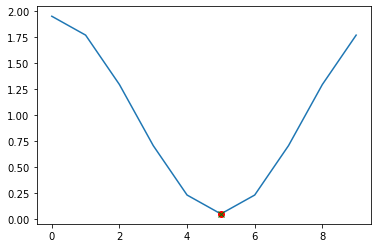

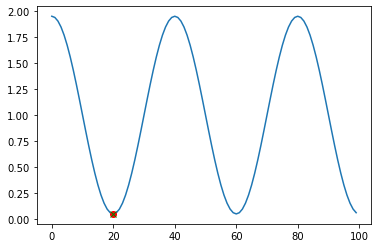

In [24]:
# tests
import matplotlib.pyplot as plt

min_ones = get_first_min_lag(np.ones(10), 3, 0.1)
print("real {}, expected {}".format(min_ones, 0))
assert min_ones == 0

test_cmdf = np.cos(np.arange(10)/10*2*np.pi)*0.95+1
plt.figure()
plt.plot(test_cmdf)
min_cos = get_first_min_lag(test_cmdf, 3, 0.2)
plt.plot(min_cos, test_cmdf[min_cos], 'ro')
expected = 5
plt.plot(expected, test_cmdf[expected], 'gx')
print("real {}, expected {}".format(min_cos, expected))
assert min_cos == expected

test_cmdf = np.cos(np.arange(100)/100*5*np.pi)*0.95+1
plt.figure()
plt.plot(test_cmdf)
min_cos = get_first_min_lag(test_cmdf, 3, 0.2)
plt.plot(min_cos, test_cmdf[min_cos], 'ro')
expected = 20
plt.plot(expected, test_cmdf[expected], 'gx')
print("real {}, expected {}".format(min_cos, expected))
assert min_cos == expected

print('All tests successful!')

### 2.4 Assemble $f_0$ Estimation Algorithm

Now that we have all parts, let's assemble the estimation function

In [25]:
DEFAULT_WIN_LEN = 512
DEFAULT_THRESHOLD = 0.1

In [26]:
def get_f0(x, fs=audio_sample_rate, frame_rate=spec_frame_rate, 
           win_len=DEFAULT_WIN_LEN, f0_min=f_min, f0_max=f_max, 
           threshold=DEFAULT_THRESHOLD):
    """
    Estimate f0 using YIN algorithm
    Parameters
    ----------
    sig : ndarray
        Audio signal
    fs : int
        Audio sample rate
    frame_rate : int
        Output frame rate
    win_len : int
        Window length for analysis frames
    f0_min : float
        Minimum frequency to be detected
    f0_max : float
        Maximum frequency to be detected
    threshold : float
        Detection threshold
    Returns
    -------
    ndarray
        Detected f0s for each frame, contains zero for frames where no periodic signal was detected.
    """
    assert len(x.shape) == 1  # make sure we got a 1D array as signal
    hop_size = int(np.round(fs/frame_rate))

    tau_min = int(np.floor(lag_for_f0(f0_max, fs)))
    tau_max = int(np.ceil(lag_for_f0(f0_min, fs)))
    
    # padding for window, this is important for alignment of annotations/detections
    x = np.pad(x, int((win_len+tau_max)/2), mode='constant')  

    win_idxs = np.arange(0, x.shape[0] - win_len, hop_size, dtype=np.int) # start indicides for windows    
    frames = [x[t:t + win_len] for t in win_idxs]
    num_win = win_idxs.shape[0]
    
    f0s = np.zeros((num_win, ))  # output array with same lenght as number of frames

    t1 = get_time()  # measure time...
    for i, frame in enumerate(frames):
        # 1) calculate difference_function for frame and tau_max
        # 2) normalize using cumulative_mean_normalization
        # 3) find smallest lag with local minimum (get_first_min_lag) using tau_min and threshold
        # 4) if lag != 0 calculate f0 for lag and put in f0s[i]
        # YOUR CODE HERE
        # 1)
        dt = difference_function(frame, tau_max)
        #2)
        cmdf = cumulative_mean_normalization(dt)
        #3)
        lag = get_first_min_lag(cmdf, tau_min, threshold)
        #4)
        if lag != 0:
            f0s[i] = f0_for_lag(lag, fs)
        
    t2 = get_time()
    print('YIN total time = {:.2f}s'.format(t2-t1))
    return f0s

YIN total time = 0.07s
YIN total time = 0.07s
All tests successful!


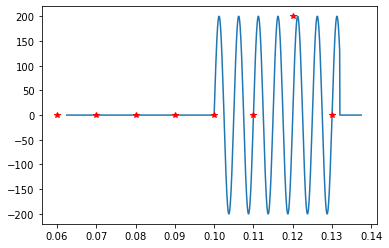

In [27]:
# tests

# test with zeros...
test_sig_time = 1
test_sig = np.zeros((audio_sample_rate*test_sig_time, ))
output = get_f0(test_sig, audio_sample_rate, spec_frame_rate)
out_size = test_sig_time*spec_frame_rate+1
assert np.allclose(output, np.zeros((out_size, )))

test_sine_len = 512  # one window size
test_sine_freq = 200 # Hz
test_sine = np.sin(np.arange(test_sine_len)/audio_sample_rate*2*np.pi*test_sine_freq)*200

# test with a short sine blip...
test_sine_pos = 0.1
tsp_idx = int(test_sine_pos*audio_sample_rate)
plt_win_size = 600
plt_window = [tsp_idx-600, tsp_idx+600]
test_sig[tsp_idx:tsp_idx+test_sine_len] = test_sine
plt.plot(np.arange(plt_window[0],plt_window[1])/audio_sample_rate, 
         test_sig[plt_window[0]:plt_window[1]])

output = get_f0(test_sig, audio_sample_rate, spec_frame_rate)

fp_idx = int(test_sine_pos*spec_frame_rate)
f_plt_win_size = int(np.ceil(plt_win_size/audio_sample_rate*spec_frame_rate))
f_plt_win = [fp_idx-f_plt_win_size, fp_idx+f_plt_win_size]
plt.plot(np.arange(f_plt_win[0], f_plt_win[1])/spec_frame_rate, output[f_plt_win[0]:f_plt_win[1]], 'r*')

assert np.max(output) == test_sine_freq # we should find exactly one window with f0
assert np.sum(output) == test_sine_freq # everything else should be zero                    

print('All tests successful!')

### 2.5 Run $f_0$ estimation on dataset

The function below runs our $f_0$ estimation algorithm on the dataset.

In [28]:
def predict_f0s_for_all(audios=audio_data['audio'], **kwargs):
    # list for collecting the detected pitches, sorted in the same way
    from madmom.audio import Signal
    detected_f0s = []
    for idx, audio in enumerate(audios):
        f0s = get_f0(audio, fs=audio_sample_rate, frame_rate=spec_frame_rate, 
                     win_len=DEFAULT_WIN_LEN, f0_min=f_min, f0_max=f_max, threshold=DEFAULT_THRESHOLD)
        detected_f0s.append(f0s)
    return detected_f0s

detected_f0s = predict_f0s_for_all()

YIN total time = 2.41s
YIN total time = 2.34s
YIN total time = 2.43s
YIN total time = 2.30s
YIN total time = 1.30s
YIN total time = 1.85s
YIN total time = 1.15s
YIN total time = 0.86s


In [29]:
# tests

assert len(detected_f0s) == len(annotation_data['annotations'])

print('All tests successful!')

All tests successful!


## Task 3: Evaluation (8 Points)

Evaluate the pitch estimation performance using simple accuracy metrics: a single frame is correct, if the estimated f0 is within the multiplicative tolerance `tol`. I.e.  `f_ref/top <= f0 < f_ref*tol` must be true.
Additionally to this (acc1), also check if the estimated frequency is within the tolerance window of double or half the reference (annotation) frequency (acc2). 
For evaluation we only consider *voiced* frames, so the annotation must be non-zero for the frame to be counted.

You can use `mir_eval.melody` for evaluation, acc1 is provided by `raw_pitch_accuracy` while acc2 is provided by `raw_chroma_accuracy`. The annotations and detections must first be processed using `to_cent_voicing` in order to work with the mir_eval evaluation functions (more details see code comments).


In [30]:
DEFAULT_TOLERANCE = 2**(50/1200)  # 50 cent tolerance (=half a semitone)

In [31]:
def evaluate_f0(detections, annotations, tol=DEFAULT_TOLERANCE):
    """
    Calculate accuracy 1 and accuracy 2 (ignoring octave errors) for given f0 detections and annotations.
    Parameters
    ----------
    detections : ndarray
        List of arrays containing the f0 estimates per frame
    annotations : ndarray
        List of arrays containing the f0 ground truth annotation per frame
    Returns
    -------
    acc1 : float
        fraction of number of correctly estimated frames in relation to number of 
        voiced frames (value != 0)
    acc2 : float
        fraction of number of correctly estimated frames in relation to number of 
        voiced frames (value != 0), ignoring factor 2 errors (f0=2*f_ref, f0=f_ref/2)
    """
    from mir_eval.melody import to_cent_voicing, raw_pitch_accuracy, raw_chroma_accuracy
    
    accs1 = []
    accs2 = []
    for det, ann in zip(detections, annotations):
        # In case you use mir_eval, you first have to convert the arrays with f0 estimates 
        # and annotations to voicing arrays using `to_cent_voicing`.
        # the required time arrays can be simply calculated using
        ref_time = np.arange(ann.shape[0])/spec_frame_rate
        # and 
        est_time = np.arange(det.shape[0])/spec_frame_rate
        
        # the tolerance in cent for mir_eval can be calculated
        cent_tol = 1200 * np.log2(tol)

        accuracy1 = 0.0
        accuracy2 = 0.0
        
        # detections and annotations should have the same length
        # check only voiced frames (ann != 0.0) if the estimate is within the tolerance window for acc1:
        # ann/tol >= det > ann*tol
        # check also if the estimate is within the windows of 2*ann or ann/2 for acc2
        # YOUR CODE HERE
        ref_voivcing, ref_cent, est_voicing, est_cent = to_cent_voicing(ref_time, ann, est_time, det)
        accuracy1 = raw_pitch_accuracy(ref_voivcing, ref_cent, est_voicing, est_cent, cent_tol)
        accuracy2 = raw_chroma_accuracy(ref_voivcing, ref_cent, est_voicing, est_cent, cent_tol)
        
        accs1.append(accuracy1)
        accs2.append(accuracy2)

    acc1 = np.mean(accs1)
    acc2 = np.mean(accs2)
    return acc1, acc2

In [32]:
# tests

acc1, acc2 = evaluate_f0([np.ones(10*fps_out)*100], [np.ones(10*fps_out)*100], tol=DEFAULT_TOLERANCE)
acc_exp = 1.0
print("real {}/{}, expected {}/{}".format(acc1, acc2, acc_exp, acc_exp))
assert acc1 == acc_exp
assert acc2 == acc_exp

acc1, acc2 = evaluate_f0([np.ones(10*fps_out)*100], 
                         [np.concatenate([np.ones(5*fps_out)*100,
                                         np.ones(5*fps_out)*200])], tol=DEFAULT_TOLERANCE)
acc_exp = 0.5
print("real {}/{}, expected {}/{}".format(acc1, acc2, acc_exp, acc_exp*2))
assert acc1 == acc_exp
assert acc2 == acc_exp*2

print('All tests successful!')

real 1.0/1.0, expected 1.0/1.0
real 0.5/1.0, expected 0.5/1.0
All tests successful!


In [33]:
# evaluate against ground truth
acc1, acc2 = evaluate_f0(detected_f0s, annotation_data['annotations'])

print('f0 estimation results\nacc1:      {:.3f}\nacc2:      {:.3f}\n'
      .format(acc1, acc2))

f0 estimation results
acc1:      0.713
acc2:      0.765



With correct implementation and default values, you should be able to achieve the performance values below:

In [34]:
# tests

assert acc1 > 0.6
assert acc2 > 0.7

print('All tests successful!')

All tests successful!


## Task 4: Visualization (5 Points)
Create a plot for the example from the beginning of the notebook, which contains:
1. spectrogram
2. f0 annotations
3. f0 estimates

<ipython-input-7-e655bf3991a0>:4: RuntimeWarning: divide by zero encountered in log2
  p = np.log2(freq/440)*12 + pref


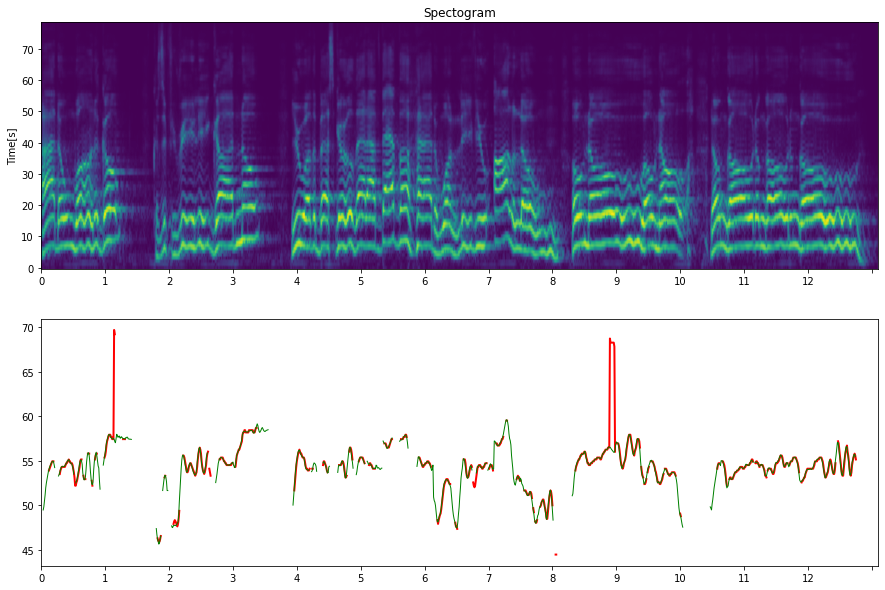

In [35]:
# plot:
example_spectrogram
f0s = detected_f0s[example_idx]
example_annotations

# you can use freq_to_semitone to plot pitch in semitones instead of frequency, 
# for the f0 and annotation contour

pred_semitone = freq_to_semitone(f0s)
ann_semitone = freq_to_semitone(example_annotations)

# YOUR CODE HERE
fig = plt.figure(figsize=(15, 10))

ax1 = plt.subplot(211)
ax1.imshow(example_spectrogram.transpose(), origin='lower', aspect='auto')
ax1.set_ylabel("Frequency[mel]")
ax1.set_title("Spectogram")
ax1.set_xticks(np.arange(0,len(example_spectrogram), 100))
ax1.set_xticklabels(np.arange(0,int(len(example_spectrogram)/100), 1))

ax2 = plt.subplot(212, sharex=ax1)
ax2.plot(pred_semitone, "r", linewidth=2)
ax2.plot(ann_semitone, "g", linewidth=1)
ax2.set_xticks(np.arange(0,len(ann_semitone), 100))
ax2.set_xticklabels(np.arange(0,int(len(ann_semitone)/100), 1))
ax1.set_ylabel("Time[s]")
pass

## Congratulations, you are done!

Reminder:
Before you turn this assignment in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).